In [1]:
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table, vstack, hstack, Column
from astropy.stats import SigmaClip, sigma_clipped_stats

from astroquery.gaia import Gaia
from astroquery.vizier import Vizier

 

import os, sys
import glob
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.gridspec as gridspec

plt.style.use('mplstyle')

# retina
%config InlineBackend.figure_format = 'retina'


In [2]:
tab = Table.read('/scratch/gpfs/sd8758/merian/catalog/DR1/9813/meriandr1_use_9813_S20A.fits')

# Select Point Source


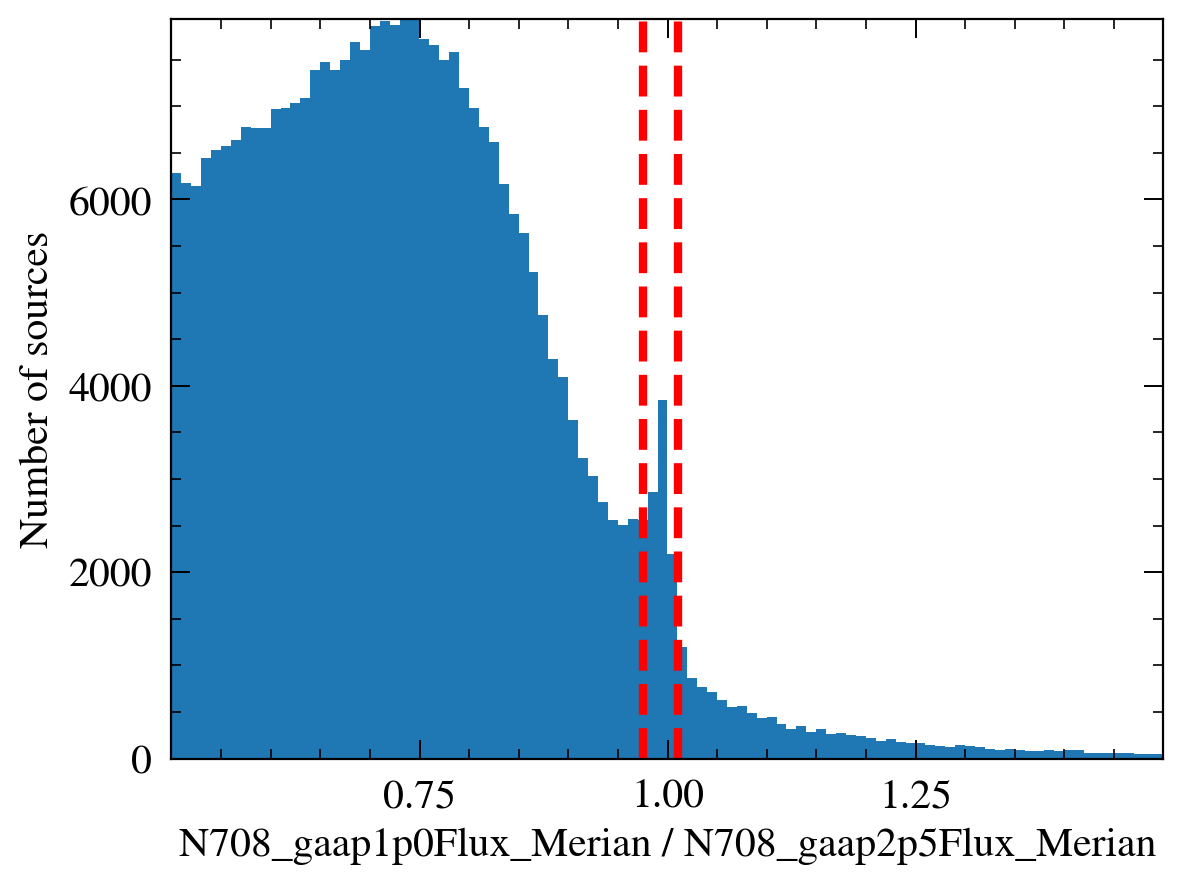

In [3]:
flux_ratio = tab['N708_gaap1p0Flux_Merian'] / tab['N708_gaap2p5Flux_Merian']
_ = plt.hist(flux_ratio[ (flux_ratio<1.5) &   (flux_ratio>0.5)  ], bins=100)


plt.axvline(0.975, color='r', linestyle='--')
plt.axvline(1.01, color='r', linestyle='--')

ps_flg = (flux_ratio < 1.01) & (flux_ratio > 0.95)
ps_tab = tab[ps_flg]

plt.xlabel('N708_gaap1p0Flux_Merian / N708_gaap2p5Flux_Merian', fontsize=15)
plt.ylabel('Number of sources', fontsize=15)

# set tick label size
_ = plt.xticks(fontsize=15)
_ = plt.yticks(fontsize=15)
_ = plt.margins(0.)

# GAIA

In [4]:
median_ra = np.nanmedian(tab['coord_ra_Merian'])
median_dec = np.nanmedian(tab['coord_dec_Merian'])

offset_ra_dcos = tab['coord_ra_Merian'] / np.cos(tab['coord_dec_Merian']) 
offset_ra = offset_ra_dcos.max() - offset_ra_dcos.min()
offset_dec = tab['coord_dec_Merian'].max() - tab['coord_dec_Merian'].min()

In [5]:


coord = SkyCoord(ra=median_ra, dec=median_dec, unit=(u.deg, u.deg), frame='icrs')
width = u.Quantity(offset_ra, u.deg)
height = u.Quantity(offset_dec, u.deg)
 

In [6]:


vizier_cat = {'SDSS': 'V/147', 'TwoMass': 'II/246', 'UKIDSS': 'II/319', 'VHS': 'II/367/vhs_dr5',
                  'VIKING': 'II/343','PS1': 'II/349', 'DES': 'II/371', 'GAIA': 'I/355/gaiadr3'}

def query_refcat(coord, width, height, survey='GAIA' ):
  
    v = Vizier(columns=["**", "+_r"], catalog=vizier_cat[survey], row_limit=100000000)   
    result = v.query_region(coord, width=width, height=height, catalog=vizier_cat[survey])
    
    if len(result) > 0: result = result[0]
    else: result = None

    return result

In [7]:
coord = SkyCoord(ra=median_ra, dec=median_dec, unit=(u.deg, u.deg), frame='icrs')
width = u.Quantity(5, u.deg)
height = u.Quantity(5, u.deg)

result = query_refcat(coord, width, height, survey='GAIA', )


gaia_tbl = Table()
gaia_tbl['RA'] = result['RA_ICRS'].data.data
gaia_tbl['DEC'] = result['DE_ICRS'].data.data
gaia_tbl['RA_ERR'] = result['e_RA_ICRS'].data.data
gaia_tbl['DEC_ERR'] = result['e_DE_ICRS'].data.data
gaia_tbl['THETA_ERR'] = np.zeros_like(gaia_tbl['RA'].data.data)
gaia_tbl['PRIMARY'] = (result['APF']==0).data ## set primary to be True
gaia_tbl['POINT_SOURCE'] = np.ones_like(gaia_tbl['RA'].data.data, dtype='bool')  ## point source is True
gaia_tbl['pmRA'] = result['pmRA'].data.data
gaia_tbl['pmDEC'] = result['pmDE'].data.data
gaia_tbl['pmRA_ERR'] = result['e_pmRA'].data.data
gaia_tbl['pmDEC_ERR'] = result['e_pmDE'].data.data
gaia_tbl['Epoch'] = np.ones_like(gaia_tbl['RA'].data.data) * 2016 # According to VIZIER, RA_ICRS are based on J2016
gaia_tbl['SourceID'] = result['Source'].data.data
gaia_tbl['RAJ2000'] = result['RAJ2000'].data.data
gaia_tbl['DECJ2000'] = result['DEJ2000'].data.data
gaia_tbl['G_MAG'] = result['Gmag'].data.data
gaia_tbl['G_MAG_ERR'] = result['e_Gmag'].data.data
gaia_tbl['BP_MAG'] = result['BPmag'].data.data
gaia_tbl['BP_MAG_ERR'] = result['e_BPmag'].data.data
gaia_tbl['RP_MAG'] = result['RPmag'].data.data
gaia_tbl['RP_MAG_ERR'] = result['e_RPmag'].data.data
 

In [8]:
# considering proper motions


time_obs = Time('2023-01-01', format='iso')
time_gaia = Time(gaia_tbl['Epoch'], format='jyear')
dra_obs_epoch = ((time_obs - time_gaia).to('yr') * gaia_tbl['pmRA'] * u.mas / u.yr / np.cos(
    np.deg2rad(gaia_tbl['DEC'] * u.deg))).to('arcsec')
dra_obs_epoch[np.isnan(dra_obs_epoch)] = 0.  # some pmra is nan, in this case use the original ra
ddec_obs_epoch = ((time_obs - time_gaia).to('yr') * gaia_tbl['pmDEC'] * u.mas / u.yr).to('arcsec')
ddec_obs_epoch[np.isnan(ddec_obs_epoch)] = 0.  # same as ra
gaia_ra, gaia_dec = gaia_tbl['RA'] + dra_obs_epoch.value, gaia_tbl['DEC'] + ddec_obs_epoch.value


# small proper motion cut
flg = ddec_obs_epoch    < 5e-3 * u.arcsec  
flg &=  dra_obs_epoch   < 5e-3 * u.arcsec  


gaia_dec = gaia_dec[flg]
gaia_ra = gaia_ra[flg]
gaia_tbl = gaia_tbl[flg]

In [9]:
# cross match with the merian catalog
coords_gaia = SkyCoord(ra=gaia_ra, dec=gaia_dec, unit=(u.deg, u.deg))
coords_merian = SkyCoord(ra=ps_tab['coord_ra_Merian'], dec=ps_tab['coord_dec_Merian'], unit=(u.deg, u.deg))

idx_merian, d2d, d3d = coords_gaia.match_to_catalog_sky(coords_merian)
matched = d2d < 1 * u.arcsec

matched_gaia = gaia_tbl[matched]
matched_merian = ps_tab[idx_merian[matched]]

dra = matched_merian['coord_ra_Merian'] - matched_gaia['RA']
ddec = matched_merian['coord_dec_Merian'] - matched_gaia['DEC']

dra_arcsec = dra * 3600
ddec_arcsec = ddec * 3600


sigma_clip = SigmaClip(sigma=3)


dra_arcsec_clipped = sigma_clip(dra_arcsec)
ddec_arcsec_clipped = sigma_clip(ddec_arcsec)
selected = ~dra_arcsec_clipped.mask  & ~ddec_arcsec_clipped.mask
dra_arcsec_clipped = dra_arcsec_clipped[selected]
ddec_arcsec_clipped = ddec_arcsec_clipped[selected]


dra_mean, dra_median, dra_std = sigma_clipped_stats(dra_arcsec)
ddec_mean, ddec_median, ddec_std = sigma_clipped_stats(ddec_arcsec)


In [10]:
dra_gaia = dra_arcsec_clipped
ddec_gaia = ddec_arcsec_clipped
dra_median_gaia = dra_median
ddec_median_gaia = ddec_median

# HSC

In [13]:
ps_coord_merian = SkyCoord(ra=ps_tab['coord_ra_Merian'], dec=ps_tab['coord_dec_Merian'], unit=(u.deg, u.deg))
ps_coord_hsc = SkyCoord(ra=ps_tab['ra_HSCS20A'], dec=ps_tab['dec_HSCS20A'], unit=(u.deg, u.deg))

idx, d2d, d3d = ps_coord_merian.match_to_catalog_sky(ps_coord_hsc)
matched = d2d < 1 * u.arcsec
matched &= ps_tab['hsc_match'].astype(bool)
matched_ps = ps_tab[matched]
 
g_50, g_45, g_55 = np.nanpercentile(matched_ps['g_gaap2p5Flux_Merian'], [50, 45, 55])
matched_ps = matched_ps[ (matched_ps['g_gaap2p5Flux_Merian'] > g_50)]

flg = (matched_ps['dec_HSCS20A'] !=0 ) & (matched_ps['ra_HSCS20A'] !=0)

dra_ps = (matched_ps['coord_ra_Merian'] - matched_ps['ra_HSCS20A'])[flg]
ddec_ps = (matched_ps['coord_dec_Merian'] - matched_ps['dec_HSCS20A'])[flg]

dra_ps_arcsec = dra_ps * 3600
ddec_ps_arcsec = ddec_ps * 3600

dra_ps_clipped = sigma_clip(dra_ps_arcsec)
ddec_ps_clipped = sigma_clip(ddec_ps_arcsec)
selected = ~dra_ps_clipped.mask  & ~ddec_ps_clipped.mask
dra_ps_clipped = dra_ps_clipped[selected]
ddec_ps_clipped = ddec_ps_clipped[selected]

dra_mean_ps, dra_median_ps, dra_std_ps = sigma_clipped_stats(dra_ps_arcsec)
ddec_mean_ps, ddec_median_ps, ddec_std_ps = sigma_clipped_stats(ddec_ps_arcsec)


dra_hsc = dra_ps_arcsec
ddec_hsc = ddec_ps_arcsec
dra_median_hsc = dra_median_ps
ddec_median_hsc = ddec_median_ps


# PLOT

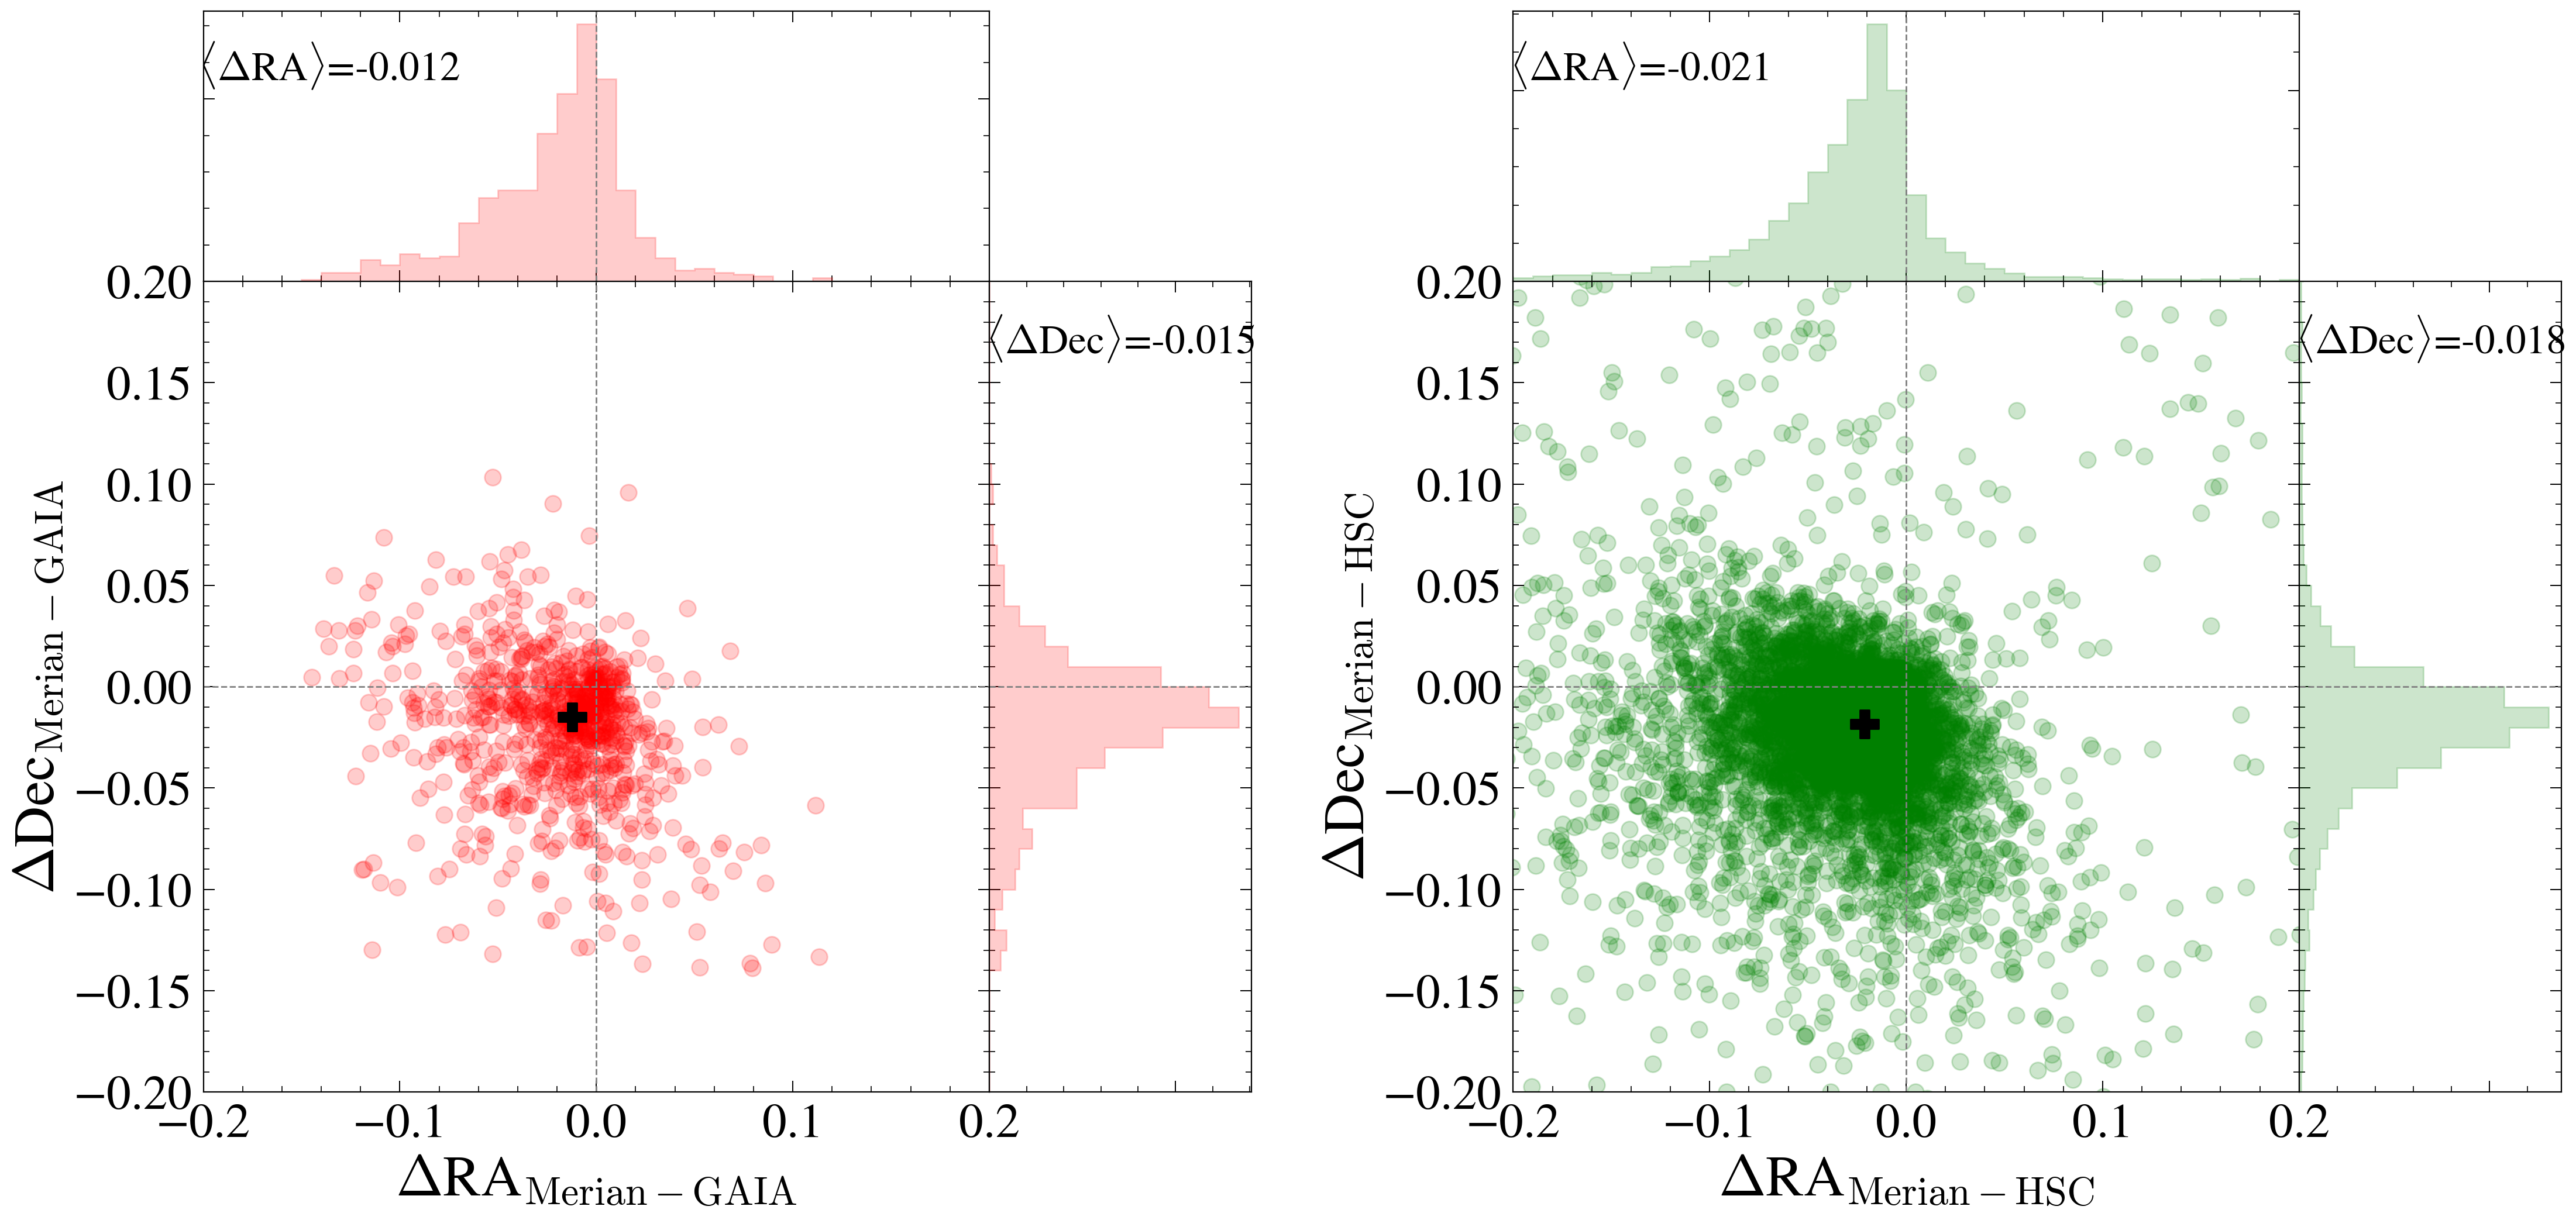

In [14]:

lim = 0.25
binwidth = 0.01

# plot

fig = plt.figure(figsize=(26,12))
gs = gridspec.GridSpec(4,9)

# LEFT PANEL
ax_main = plt.subplot(gs[1:4, :3])
ax_xDist = plt.subplot(gs[0, :3],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:4, 3],sharey=ax_main)
ax_xDist.tick_params(axis='x', labelbottom=False, labelleft=False)
ax_yDist.tick_params(axis='y', labelbottom=False, labelleft=False)
ax_xDist.tick_params(axis='y', labelbottom=False, labelleft=False)
ax_yDist.tick_params(axis='x', labelbottom=False, labelleft=False)

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_xDist.hist(dra_gaia, bins=bins, color='red', histtype='step',fill =True, alpha=0.2, lw=1)
ax_yDist.hist(ddec_gaia, bins=bins, color='red', orientation='horizontal',align='mid', histtype='step', fill=True, alpha=0.2, lw=1)
ax_xDist.axvline(x=0, ymin=0, ymax=1, color='grey', lw=1, ls='--')
ax_yDist.axhline(y=0, xmin=0, xmax=1, color='grey', lw=1, ls='--')
ax_xDist.text(0.16, 0.8, r'$\langle\Delta$RA$\rangle$=%.3f'%(dra_median_gaia), horizontalalignment='center', verticalalignment='center', transform=ax_xDist.transAxes, fontsize=25)
ax_yDist.text(0.5, 0.93, r'$\langle\Delta$Dec$\rangle$=%.3f'%(ddec_median_gaia), horizontalalignment='center', verticalalignment='center', transform=ax_yDist.transAxes, fontsize=25)

ax_main.scatter(dra_gaia, ddec_gaia, color='r', alpha=0.2)
ax_main.scatter(dra_median_gaia, ddec_median_gaia, marker='P', s=300, color='k')
ax_main.axhline(y=0, xmin=0, xmax=1, color='grey', lw=1, ls='--')
ax_main.axvline(x=0, ymin=0, ymax=1, color='grey', lw=1, ls='--')
ax_main.set_xlim(-0.2,0.2)
ax_main.set_ylim(-0.2,0.2)
ax_main.set_xlabel(r'$\Delta$RA$_\mathrm{Merian-GAIA}$')
ax_main.set_ylabel(r'$\Delta$Dec$_\mathrm{Merian-GAIA}$')
# ax_main.text(0.13, 0.9, 'N708', horizontalalignment='center', verticalalignment='center', transform=ax_main.transAxes, fontsize=35)


# RIGHT PANEL
ax_main2 = plt.subplot(gs[1:4, 5:8])
ax_xDist2 = plt.subplot(gs[0, 5:8],sharex=ax_main)
ax_yDist2 = plt.subplot(gs[1:4, 8],sharey=ax_main)
ax_xDist2.tick_params(axis='x', labelbottom=False, labelleft=False)
ax_yDist2.tick_params(axis='y', labelbottom=False, labelleft=False)
ax_xDist2.tick_params(axis='y', labelbottom=False, labelleft=False)
ax_yDist2.tick_params(axis='x', labelbottom=False, labelleft=False)

ax_main2.scatter(dra_hsc, ddec_hsc, color='g', alpha=0.2)
ax_main2.scatter(dra_median_hsc, ddec_median_hsc, marker='P', s=300, color='k')
ax_main2.axhline(y=0, xmin=0, xmax=1, color='grey', lw=1, ls='--')
ax_main2.axvline(x=0, ymin=0, ymax=1, color='grey', lw=1, ls='--')
ax_main2.set_xlim(-0.2,0.2)
ax_main2.set_ylim(-0.2,0.2)
ax_main2.set_xlabel(r'$\Delta$RA$_\mathrm{Merian-HSC}$')
ax_main2.set_ylabel(r'$\Delta$Dec$_\mathrm{Merian-HSC}$')
# ax_main2.text(0.13, 0.9, 'N540', horizontalalignment='center', verticalalignment='center', transform=ax_main2.transAxes, fontsize=35)

ax_xDist2.hist(dra_hsc, bins=bins, color='g', histtype='step',fill =True, alpha=0.2, lw=1)
ax_yDist2.hist(ddec_hsc, bins=bins, color='g', orientation='horizontal',align='mid', histtype='step', fill=True, alpha=0.2, lw=1)
ax_xDist2.axvline(x=0, ymin=0, ymax=1, color='grey', lw=1, ls='--')
ax_yDist2.axhline(y=0, xmin=0, xmax=1, color='grey', lw=1, ls='--')
ax_xDist2.text(0.16, 0.8, r'$\langle\Delta$RA$\rangle$=%.3f'%(dra_median_hsc), horizontalalignment='center', verticalalignment='center', transform=ax_xDist2.transAxes, fontsize=25)
ax_yDist2.text(0.5, 0.93, r'$\langle\Delta$Dec$\rangle$=%.3f'%(ddec_median_hsc), horizontalalignment='center', verticalalignment='center', transform=ax_yDist2.transAxes, fontsize=25)


plt.subplots_adjust(wspace=0, hspace=0)
plt.show()